# Customer Segmentation - RFM Analysis

Here I am trying out customer segmentation on a retail data using RFM Analysis. RFM (Recency, Frequency, Monetary) analysis is a popularly used technique in marketing to identify high-value customers based on the purchasing behavior. It helps us to understand customer engagement and how to effectively use marketing.

##### Objectives

To try different clustering approaches (Kmeans, hierarchical clustering and dbscan and theirby trying to find the effectivenes of different algorithms in clustering the customers for RFM analysis.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster._dbscan import DBSCAN

In [2]:
import plotly.graph_objects as go
import plotly.express as px

In [3]:
data = pd.read_csv("Online_retail_data.csv")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Invoice      1000 non-null   object 
 1   Description  1000 non-null   object 
 2   Quantity     1000 non-null   int64  
 3   InvoiceDate  1000 non-null   object 
 4   Price        1000 non-null   float64
 5   Customer ID  1000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 47.0+ KB


In [5]:
data.describe()

,Quantity,Price
count,1000.000000,1000.000000
mean,9.977000,49.881190
std,5.470868,28.834394
min,1.000000,1.020000
25%,5.000000,24.027500
50%,10.000000,50.080000
75%,15.000000,75.097500
max,19.000000,99.970000


### Preprocessing

In [6]:
data.isna().sum()
# no missing values

Invoice        0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
dtype: int64

In [7]:
data.duplicated().sum()

np.int64(0)

In [8]:
# Check for negative values or other issues
data[(data["Quantity"]<=0) & (data["Price"]<=0)]

,Invoice,Description,Quantity,InvoiceDate,Price,Customer ID


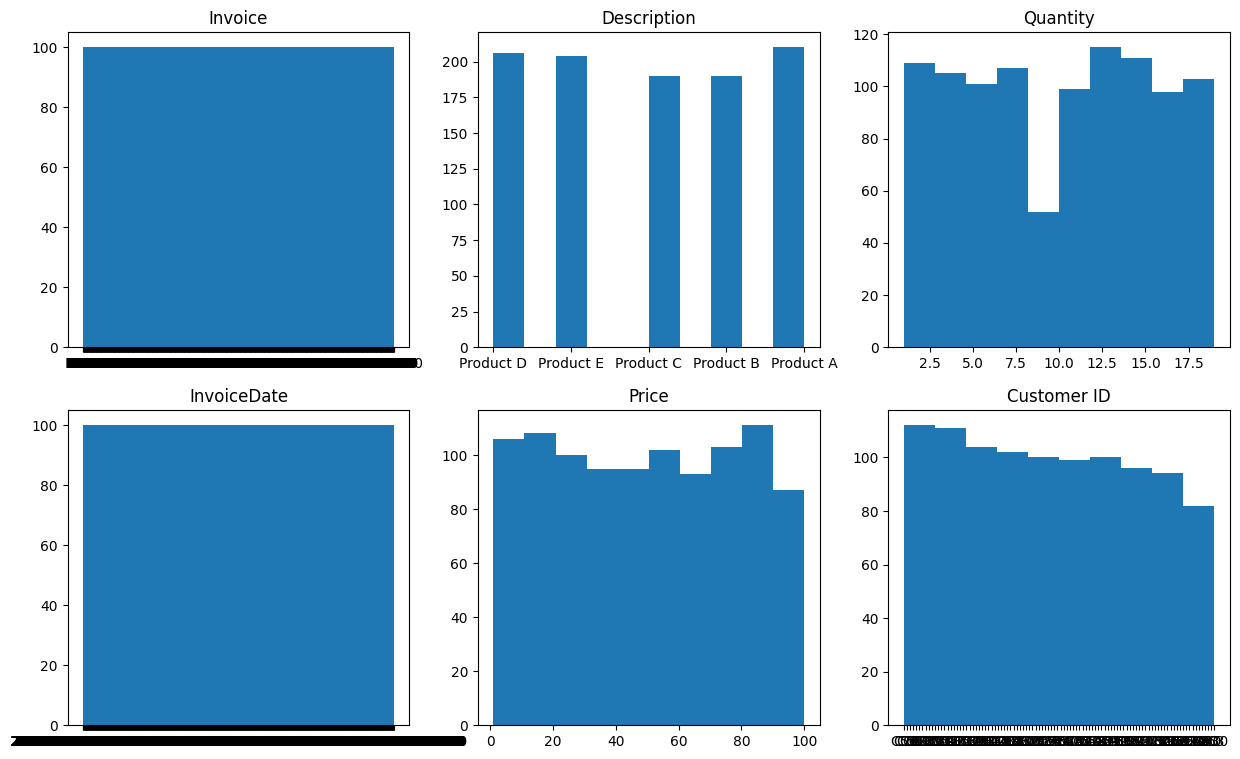

In [9]:
i = 1
plt.subplots(nrows=2,ncols=3,figsize=(15,9))
for c in data.columns:
    plt.subplot(2,3,i)
    plt.hist(data[c])
    plt.title(c)
    i+=1
plt.show()

### Feature Engineering

##### Let us build Recency, Frequency and Monetary columns from the given data

In [10]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

In [11]:
data["Total_sum"] = data["Quantity"]*data["Price"]

In [12]:
latest_date = data["InvoiceDate"].max()

In [13]:
df_rfm = data.groupby(by='Customer ID').agg({"InvoiceDate":lambda x: (latest_date - x.max()).days,"Invoice":"count","Total_sum":"sum"}).reset_index()

In [14]:
df_rfm.columns = ["Customer ID","Recency","Frequency","Monetary"]

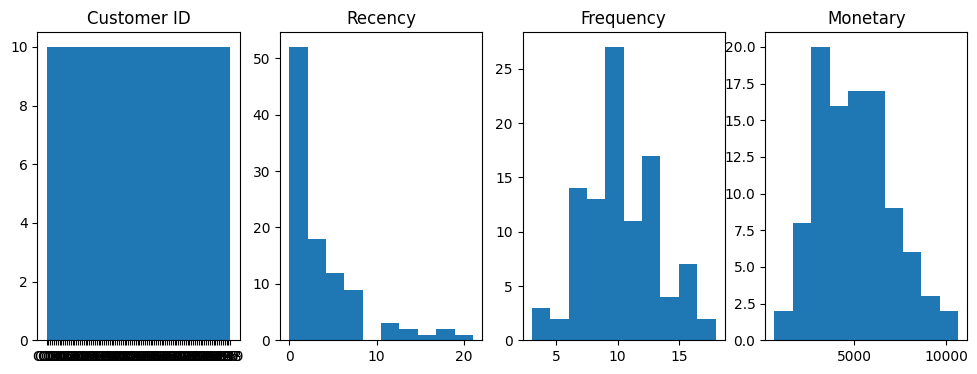

In [15]:
i = 1
plt.subplots(nrows=1,ncols=4,figsize=(12,4))
for c in df_rfm.columns:
    plt.subplot(1,4,i)
    plt.hist(df_rfm[c])
    plt.title(c)
    i+=1
plt.show()

In [16]:
# Since Recency is skewed, we need to transform to log scale

df_rfm["recency_log"] = np.log(df_rfm["Recency"]+1)
df_rfm["frequency_log"] = np.log(df_rfm["Frequency"])
df_rfm["monetary_log"] = np.log(df_rfm["Monetary"])


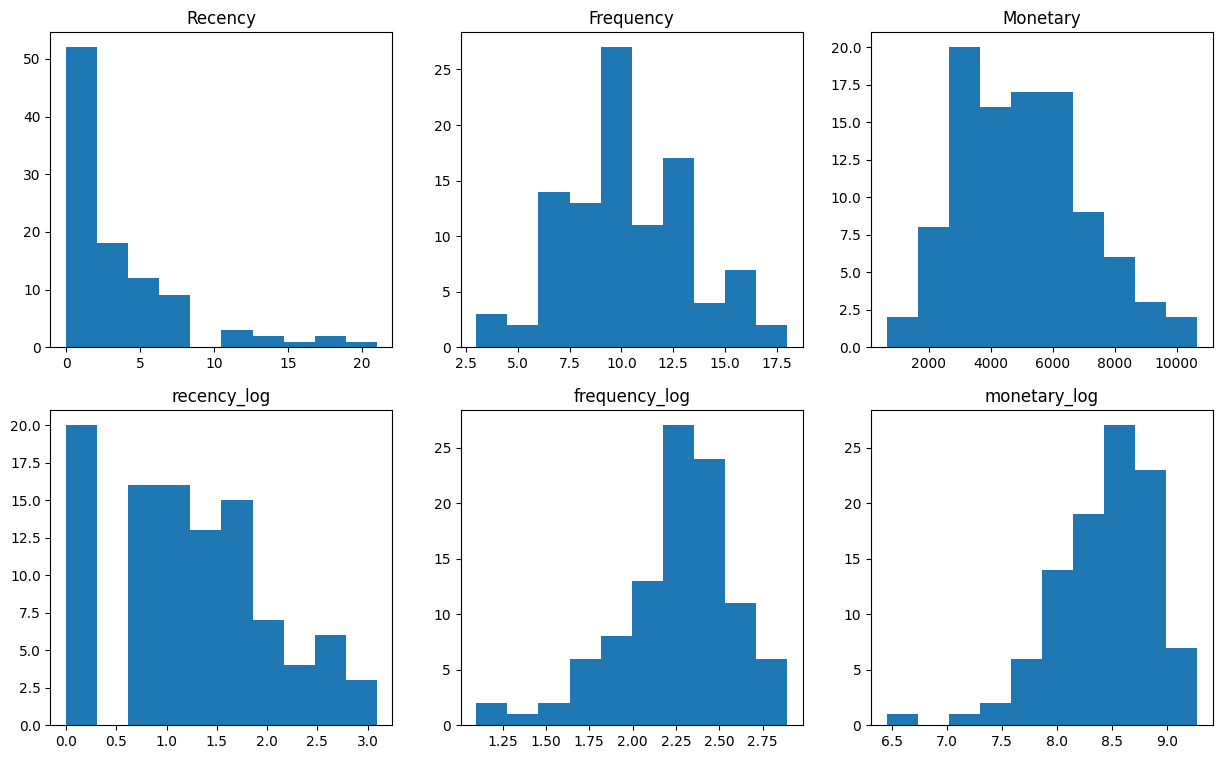

In [17]:
i = 1
plt.subplots(nrows=2,ncols=3,figsize=(15,9))
for c in df_rfm.columns.tolist()[1:]:
    plt.subplot(2,3,i)
    plt.hist(df_rfm[c])
    plt.title(c)
    i+=1
plt.show()

In [18]:
# standardisation
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

rfm_scaled = pd.DataFrame(sc.fit_transform(df_rfm[["recency_log","frequency_log","monetary_log"]]),columns=["recency_log","frequency_log","monetary_log"])

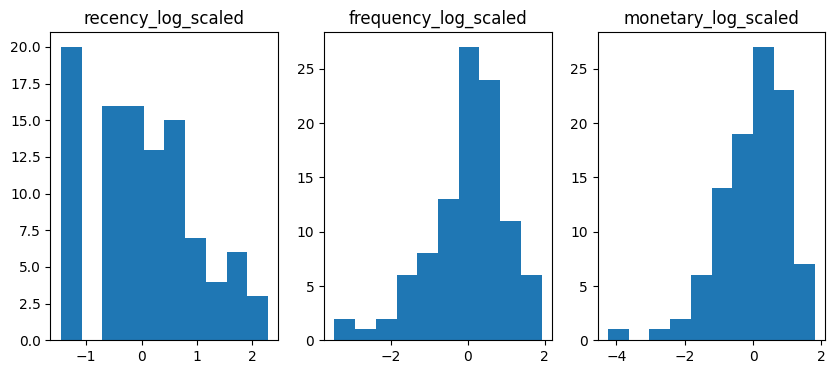

In [19]:
i = 1
plt.subplots(nrows=1,ncols=3,figsize=(10,4))
for c in rfm_scaled.columns:
    plt.subplot(1,3,i)
    plt.hist(rfm_scaled[c])
    plt.title(c+str("_scaled"))
    i+=1
# plt.show()

## Vizualisation and Analysis

Based on the RFM values, we are assuming we can find different types of customer groups. Some clusters we are expecting to find would be

1. Best Customers (High R, F, and M)

2. Loyal Customers (High F, moderate M and R)

3. Big Spenders (High M, but lower R or F)

4. Risk Category (Low R, F, and M)

5. New Customers (High R, low F and M)

NB : High Recency = less number of days 

Let us plot the RFM data and see which of these groups can be obtained from our data.

In [128]:
fig = px.scatter(data_frame=df_rfm,x="Frequency",y="Monetary",title="fig 1 : Frequency v/s Monetary",color="Recency")
fig.show()

In [123]:
fig = px.scatter(data_frame=df_rfm,x="Recency",y="Monetary",title="fig 2 : Recency v/s Monetary")
fig.show()

In [126]:
fig = px.scatter(data_frame=df_rfm,x="Recency",y="Frequency",title="fig 3 : Recency v/s Frequency")
fig.show()

#### Observations

1. From fig 1 we could see that the customers distributed across top right could be grouped as a cluster with MODERATE-HIGH MONETARY, MODERATE-HIGH FREQUENCY and MODERATE-HIGH RECENCY which may fall under category Best Customers and Loyal Customers.

2. From fig 2,3 we could also observe that there can be group formed by customers with LOW MONETARY, LOW FREQUENCY and LOW RECENCY which may fall under categories NEW CUSTOMERS or RISK category customers.

3. We are not sure wheather we could get clusters for these 4 categories distinctively as the distributions does not give us a very clear clusters. So we could expect maximum 4 clusters for Best Customers, Loyal Customers, New customer or Risk category customers and minimum 2 clusters for best customer and risk customers.

## K-Means

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [26]:
wcss = []
kmeans_score = []
for i in range(2,11):
    m = KMeans(n_clusters=i)
    m.fit(rfm_scaled)
    wcss.append(m.inertia_)
    kmeans_score.append(silhouette_score(rfm_scaled,m.labels_))

In [27]:
kmeans_score

[np.float64(0.3625081959919717),
 np.float64(0.3711245217645957),
 np.float64(0.32490814508377747),
 np.float64(0.26427662061211554),
 np.float64(0.2846259490765183),
 np.float64(0.29291807390200597),
 np.float64(0.29860139911162475),
 np.float64(0.26181292464508205),
 np.float64(0.2753241174078703)]

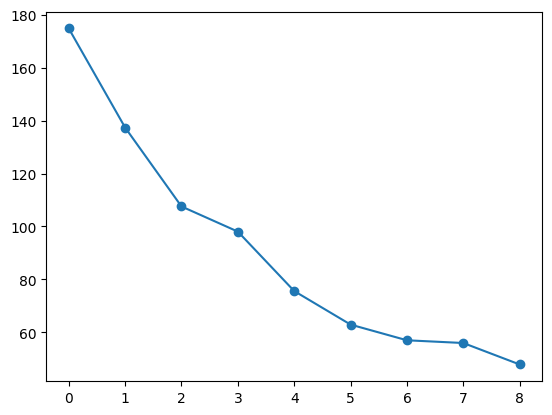

In [28]:
plt.plot(wcss,marker="o")

In [29]:
# Apply KMeans with optimal k which is k = 3

k_mean_opt = KMeans(n_clusters=2,init="k-means++",random_state=42)
k_mean_opt.fit(rfm_scaled)

KMeans(n_clusters=2, random_state=42)

In [30]:
df_rfm["kmeans_clusters"] = k_mean_opt.labels_

In [31]:
kmeans_score = silhouette_score(rfm_scaled,df_rfm["kmeans_clusters"])
print(kmeans_score)

0.3625081959919717


In [43]:
df_rfm["kmeans_clusters"] = df_rfm["kmeans_clusters"].astype("str")
px.scatter_3d(data_frame=df_rfm,z="Monetary",y="Recency",x="Frequency",color="kmeans_clusters",title="kmeans",height=400,width=600)

#### Observations
* kmeans algorithm shows highest silhouette score and lowest inertia when k=2.

* Analysing the 3D scatter plot we can observe that Cluster 0 contains customers with High Recency, High Frequency and High Monetary which represents best customers and trusted customers. They have purhased recently, very frequently, spend money.

* Similarly Cluster 1 is formed by customers with comparatively Low Recency, Low Frequency and Low Monetary represents the group to which more marketing statergies needs to be applied. 


## Hierarchical Clustering

In [45]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster

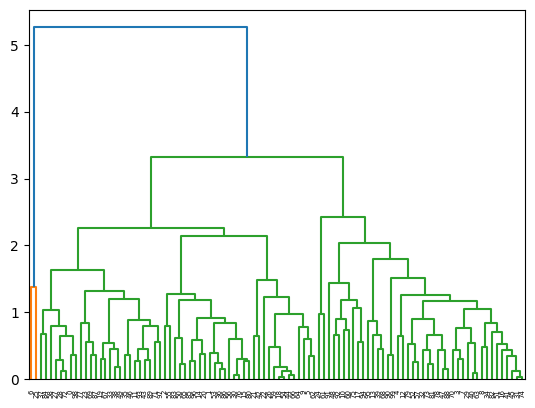

In [46]:
plt.Figure(figsize=(10,6))
z = linkage(rfm_scaled,method="weighted")
dendrogram(z)
plt.show()

In [47]:
df_rfm["Hierarchical_clusters"] = fcluster(z,3,criterion="maxclust")

In [72]:
hierarchical_score = silhouette_score(rfm_scaled,df_rfm["Hierarchical_clusters"])
print(hierarchical_score )

0.3509375732114118


In [53]:
df_rfm["Hierarchical_clusters"] = df_rfm["Hierarchical_clusters"].astype("str")
px.scatter_3d(data_frame=df_rfm,z="Monetary",y="Recency",x="Frequency",color="Hierarchical_clusters",title="Hierarchical",height=400,width=600)

#### Observations

* By tuning the paramters number of clusters and linkage criteria we found that the parameters giving best silhouette score is when used k=3 and criteria=weighted. 
* By analysing the clusters we can see that Cluster 3 and Cluster 2 are almost similar to the clusters formed by kmeans. The third cluster (Cluster 1) here is a sub-cluster of Cluster-3 which formed by customers with lowest Monetary, Frequency and Recency.
* The newly found cluster Cluster-1 is very useful as it shows the customers of High Risk Category.  

## DBSCAN

In [54]:
# standardisation
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sc = MinMaxScaler()

rfm_scaled = pd.DataFrame(sc.fit_transform(df_rfm[["recency_log","frequency_log","monetary_log"]]),columns=["recency_log","frequency_log","monetary_log"])

In [97]:
# dbs = DBSCAN(eps=0.15,min_samples=4) - 0.3
dbs = DBSCAN(eps=0.19,min_samples=3,metric="manhattan") 
dbs.fit(rfm_scaled)
df_rfm["DBSCAN_clusters"] = dbs.fit_predict(rfm_scaled)

In [98]:
df_rfm["DBSCAN_clusters"].value_counts()

DBSCAN_clusters
 0    58
 1    20
-1    18
 2     4
Name: count, dtype: int64

In [99]:
dbscan_score = silhouette_score(rfm_scaled,df_rfm["DBSCAN_clusters"])
print(dbscan_score)

0.2235626059506484


In [100]:
# Removing the noise and re-calculate score
ind = df_rfm[(df_rfm["DBSCAN_clusters"]!=-1)].index
dbscan_without_noise = silhouette_score(rfm_scaled.iloc[ind],df_rfm.iloc[ind]["DBSCAN_clusters"])
print(dbscan_without_noise)

0.3481445372827663


In [80]:
df_rfm["DBSCAN_clusters"] = df_rfm["DBSCAN_clusters"].astype("str")
fig = px.scatter(data_frame=df_rfm,x="Recency",y="Monetary",color="DBSCAN_clusters",title="Recency v/s Monetary")
fig.show()

In [81]:
df_rfm["DBSCAN_clusters"]=df_rfm["DBSCAN_clusters"].astype("str")
px.scatter_3d(data_frame=df_rfm,z="Monetary",y="Recency",x="Frequency",color="DBSCAN_clusters",title = "DBSCAN",height=400,width=600)

### Observations

1. Advantage of using dbscan is that it can find the noise points as well. 
2. The clusters are formed differently from the other 2 methods. Because when observing we could see that dbscan clustering is very much dependant on the Recency feature. Cluster 1 was formed by customers with highest recency (0 days) 


### Conclusion 

#### Let's compare the scores of each clustering method 

In [121]:
print("Method \t\t\t\t Score \t\t\t Number of Clusters")
print("kmeans\t\t\t\t",kmeans_score,"\t\t",2)
print("Hierarchical\t\t\t",hierarchical_score,"\t\t",3)
print("DBSCAN (including noise)\t",dbscan_score,"\t\t",3)
print("DBSCAN (removing noise)\t\t",dbscan_without_noise,"\t\t",3)

Method 				 Score 			 Number of Clusters
kmeans				 0.3625081959919717 		 2
Hierarchical			 0.3509375732114118 		 3
DBSCAN (including noise)	 0.2235626059506484 		 3
DBSCAN (removing noise)		 0.3481445372827663 		 3


##### So comparing 3 methods Hierarchical clustering was giving us the most efficient customer segmentation based on the Recency,Frequency and Monetary parameters.